# Redução da Dimensionalidade 👌

## Bibliotecas

In [363]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

## Importando os dados

In [346]:
data = pd.read_csv('./datasets/arrhythmia_csv.csv')

target = data['class'].name

print(f"O dataset possui {data.shape[0] - 1} linhas e {data.shape[1]} colunas")
data.head()

O dataset possui 451 linhas e 280 colunas


,age,sex,height,weight,QRSduration,PRinterval,Q-Tinterval,Tinterval,Pinterval,QRS,...,chV6_QwaveAmp,chV6_RwaveAmp,chV6_SwaveAmp,chV6_RPwaveAmp,chV6_SPwaveAmp,chV6_PwaveAmp,chV6_TwaveAmp,chV6_QRSA,chV6_QRSTA,class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7


In [347]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, age to class
dtypes: float64(125), int64(155)
memory usage: 988.9 KB


## Tratando valores nulos e outliers

In [348]:
data_t = data.copy()

data_t.isnull().sum().sort_values(ascending=False)

J                             376
P                              22
T                               8
QRST                            1
heartrate                       1
                             ... 
chV2_RPwave                     0
chV2_SPwave                     0
chV2_intrinsicReflecttions      0
chV2_RRwaveExists               0
class                           0
Length: 280, dtype: int64

In [349]:
data_t.drop("J", axis=1, inplace=True)

data_t.fillna(data_t.mean(), inplace=True)

print(f"O dataset possui {data.shape[0] - 1} linhas e {data.shape[1]} colunas")

O dataset possui 451 linhas e 280 colunas


## Definição para o treinamento e teste

Aqui separamos nosso conjunto de treino e teste, juntamente com a normalização dos mesmos.

In [350]:
X = data_t.drop(target, axis=1)
y = data[target]

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

## Modelo de classificação usando o dataset inteiro, sem redução de dimensionalidade

- Algorito utilizado: Árvores de decisão

In [356]:
pipeline_not_pca = Pipeline([
    ('clf', DecisionTreeClassifier(max_depth=5, random_state=25))
])

pipeline_not_pca.fit(X_train, y_train)

y_pred_not_pca = pipeline_not_pca.predict(X_test)

accuracy_not_pca = accuracy_score(y_test, y_pred_not_pca)
f"Acurácia do modelo sem PCA: {accuracy_not_pca}"

'Acurácia do modelo sem PCA: 0.6483516483516484'

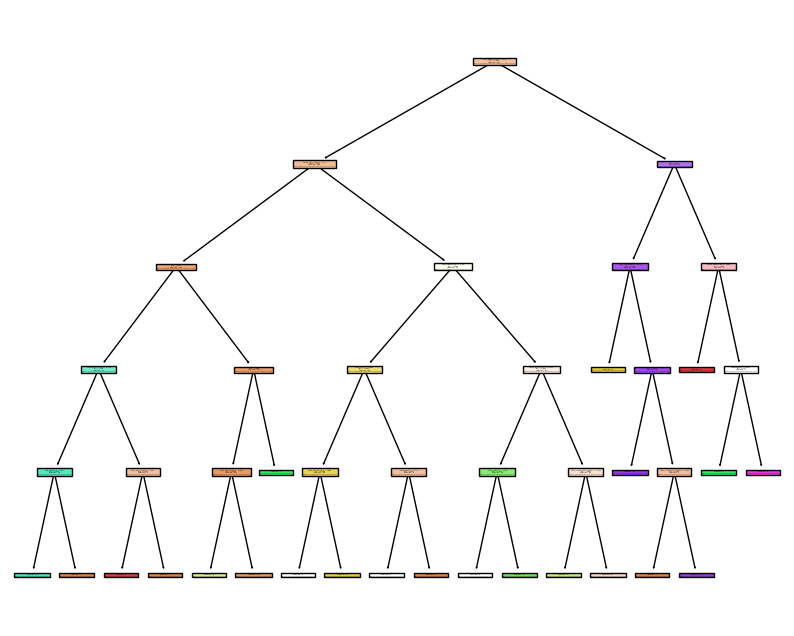

In [357]:
plt.figure(figsize=(10, 8))
plot_tree(pipeline_not_pca.named_steps['clf'], feature_names=data_t.columns, filled=True)
plt.show()

## Redução da dimensionalidade e modelo de classificação

Aqui utilizamos o método PCA para realizar a redução da dimensionalidade e em seguida aplicamos o mesmo modelo de árvore de decisão.

In [385]:
list_accs = []
i = 1

while i < 139: # testando pela metade o número de features 
    pipeline_with_pca = Pipeline([
        ('pca', PCA(n_components=i)),
        ('clf', DecisionTreeClassifier(max_depth=5, random_state=25))
    ])

    pipeline_with_pca.fit(X_train, y_train)

    y_pred_with_pca = pipeline_with_pca.predict(X_test)

    accuracy_with_pca = accuracy_score(y_test, y_pred_with_pca)

    list_accs.append([accuracy_with_pca, i])
    i += 1

best_acc = max(list_accs, key=lambda x: x[0])

best_pair = min([pair for pair in list_accs if pair[0] == best_acc[0]], key=lambda x: x[1])
acc, n_components = best_pair

f"Acurácia do modelo com PCA: {acc} com {n_components} componentes"

'Acurácia do modelo com PCA: 0.6373626373626373 com 11 componentes'

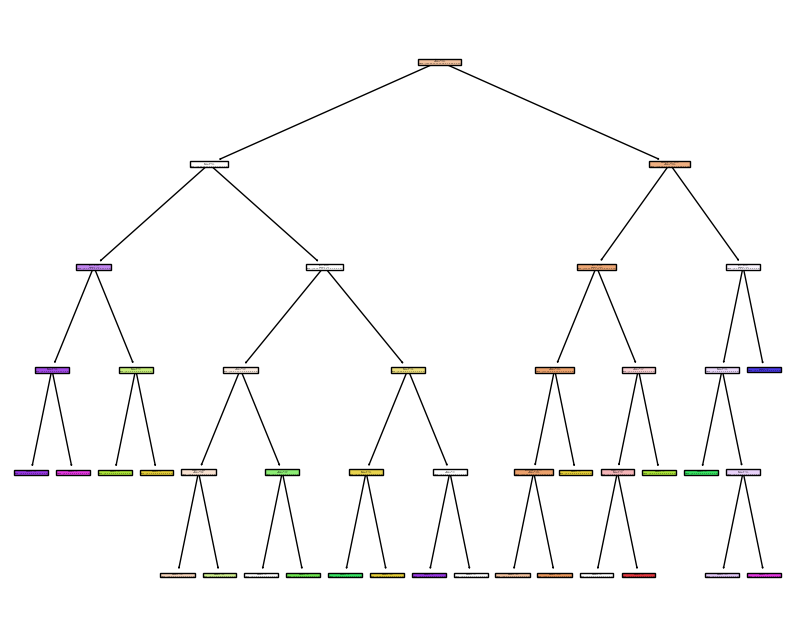

In [386]:
pipeline_with_pca = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('clf', DecisionTreeClassifier(max_depth=5, random_state=25))
])

pipeline_with_pca.fit(X_train, y_train)

y_pred_with_pca = pipeline_with_pca.predict(X_test)

accuracy_with_pca = accuracy_score(y_test, y_pred_with_pca)

plt.figure(figsize=(10, 8))
plot_tree(pipeline_with_pca.named_steps['clf'], feature_names=data_t.columns, filled=True)
plt.show()

## Comparação dos arquivos finais

In [387]:
import os

data_r = pd.DataFrame(PCA(n_components=13).fit_transform(X))
data_r['class'] = y
data_r.to_csv('./datasets/arrhythmia_csv_pca.csv')

file_init = "./datasets/arrhythmia_csv.csv"
file_end = "./datasets/arrhythmia_csv_pca.csv"

In [388]:
print(f"Tamanho do arquivo inicial, sem a redução da dimensionalidade, --> {os.stat(file_init).st_size / (1024):.3f} kB")
print(f"Tamanho do arquivo inicial, sem a redução da dimensionalidade, --> {os.stat(file_end).st_size / (1024):.3f} kB")

Tamanho do arquivo inicial, sem a redução da dimensionalidade, --> 403.354 kB
Tamanho do arquivo inicial, sem a redução da dimensionalidade, --> 113.664 kB


In [389]:
reducao_p = abs(((os.stat(file_end).st_size - os.stat(file_init).st_size) / os.stat(file_end).st_size) * 100)

f"Redução de {reducao_p:.2f}%"

'Redução de 254.86%'

In [38]:
import random

random.randint(1, 2000)

120